In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# --- Load Dataset ---
# Import the dataset uploaded to the repo
url = "https://raw.githubusercontent.com/MaharLeika18/Data-Mining---Python/refs/heads/main/Finals_Act/Groceries_dataset.csv"
data = pd.read_csv(url)

# Inspect first few rows
print(data.head())

   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk


In [7]:
# --- Data Preprocessing ---
# One-hot encode all items 
transactions = data.groupby('Member_number')[
    'itemDescription'].apply(list).values.tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Inspect
df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,True,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [8]:
# --- Use apriori ---
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)

print(frequent_itemsets.head())

    support                 itemsets
0  0.015393  (Instant food products)
1  0.078502               (UHT-milk)
2  0.031042          (baking powder)
3  0.119548                   (beef)
4  0.079785                (berries)


In [19]:
# --- Use association_rules ---
# Confidence > 0.6
rulesConfi = association_rules(
    frequent_itemsets, metric="confidence", min_threshold=0.6
    )

print(rulesConfi.head())

            antecedents         consequents  antecedent support  \
0              (liquor)        (whole milk)            0.026424   
1             (mustard)        (whole milk)            0.023345   
2   (UHT-milk, sausage)  (other vegetables)            0.018471   
3    (UHT-milk, yogurt)  (other vegetables)            0.023345   
4  (beef, bottled beer)        (whole milk)            0.020780   

   consequent support   support  confidence      lift  representativity  \
0            0.458184  0.016675    0.631068  1.377325               1.0   
1            0.458184  0.014110    0.604396  1.319112               1.0   
2            0.376603  0.011801    0.638889  1.696450               1.0   
3            0.376603  0.014366    0.615385  1.634039               1.0   
4            0.458184  0.013084    0.629630  1.374186               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0  0.004568    1.468607       0.281390  0.035636   0.319083    0.333731 

In [17]:
# Lift > 1.2
rulesLift = association_rules(
    frequent_itemsets, metric="lift", min_threshold=1.2
    )

print(rulesLift.head())

       antecedents      consequents  antecedent support  consequent support  \
0  (bottled water)       (UHT-milk)            0.213699            0.078502   
1       (UHT-milk)  (bottled water)            0.078502            0.213699   
2        (chicken)       (UHT-milk)            0.100564            0.078502   
3       (UHT-milk)        (chicken)            0.078502            0.100564   
4         (coffee)       (UHT-milk)            0.114931            0.078502   

    support  confidence      lift  representativity  leverage  conviction  \
0  0.021293    0.099640  1.269268               1.0  0.004517    1.023477   
1  0.021293    0.271242  1.269268               1.0  0.004517    1.078960   
2  0.010518    0.104592  1.332350               1.0  0.002624    1.029138   
3  0.010518    0.133987  1.332350               1.0  0.002624    1.038594   
4  0.012827    0.111607  1.421715               1.0  0.003805    1.037264   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.

In [49]:
# Expand multi-item rules into one row per (antecedent, consequent) pair
expandedConfi = []
expandedLift = []

for _, row in rulesConfi.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            expandedConfi.append({
                'antecedent': a,
                'consequent': c,
                'confidence': row['confidence'],
                'support': row['support']
            })

for _, row in rulesLift.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            expandedLift.append({
                'antecedent': a,
                'consequent': c,
                'confidence': row['confidence'],
                'support': row['support']
            })

expandedConfi_df = pd.DataFrame(expandedConfi)
expandedLift_df = pd.DataFrame(expandedLift)

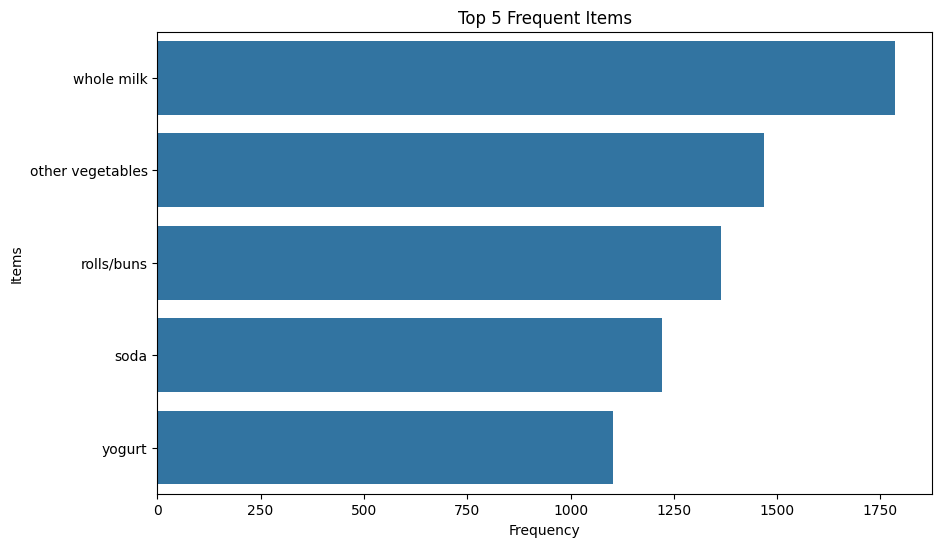

In [14]:
# --- Display top 5 rules w/ metrics --- 
# Bar Chart
item_frequencies = df.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=item_frequencies.head(5).values,
            y=item_frequencies.head(5).index)
plt.title('Top 5 Frequent Items')
plt.xlabel('Frequency')
plt.ylabel('Items')
plt.show()

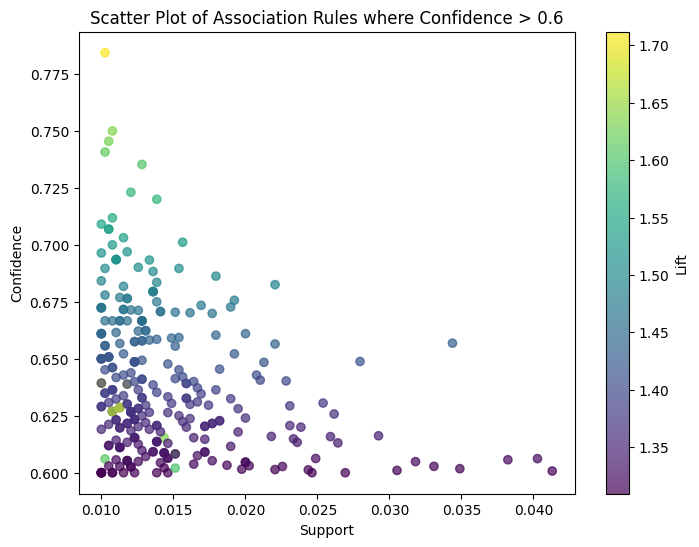

In [20]:
# Scatter Plot of Rules(Support vs Confidence) where Confidence > 0.6
plt.figure(figsize=(8, 6))
scatter = plt.scatter(rulesConfi['support'], rulesConfi['confidence'],
                      c=rulesConfi['lift'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Scatter Plot of Association Rules where Confidence > 0.6')
plt.show()

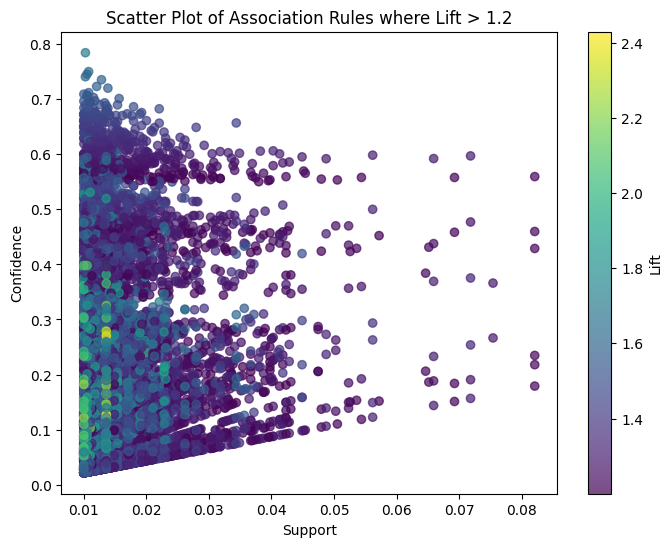

In [21]:
# Scatter Plot of Rules(Support vs Confidence) where Lift > 1.2
plt.figure(figsize=(8, 6))
scatter = plt.scatter(rulesLift['support'], rulesLift['confidence'],
                      c=rulesLift['lift'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Scatter Plot of Association Rules where Lift > 1.2')
plt.show()

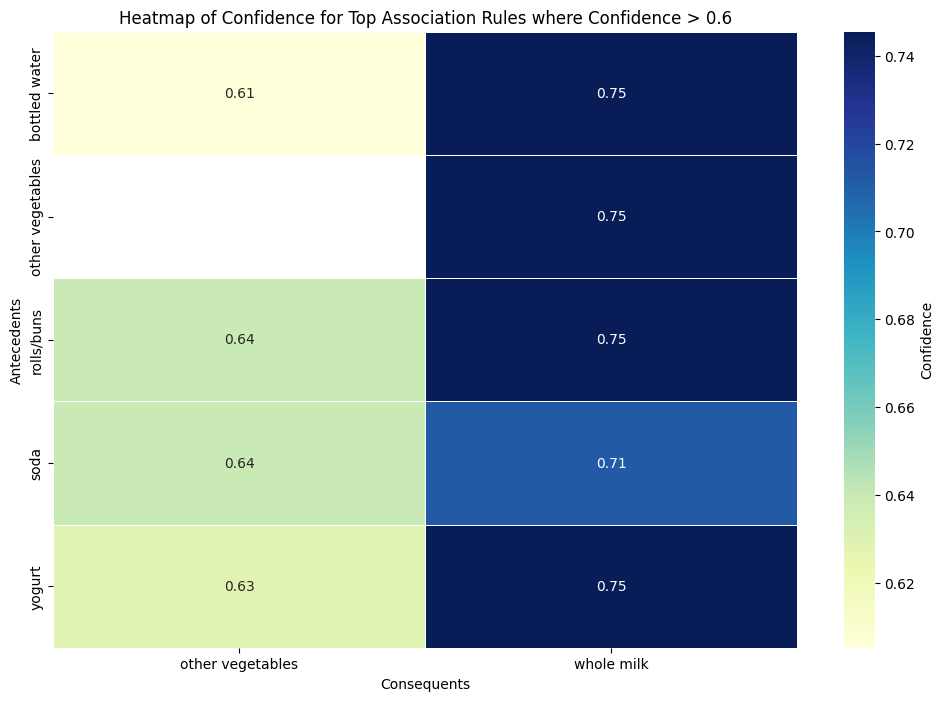

In [54]:
# Heatmap of Confidence where Confidence > 0.6
top_ants = expandedConfi_df.groupby('antecedent')['support'].sum().nlargest(5).index
top_cons = expandedConfi_df.groupby('consequent')['support'].sum().nlargest(5).index

filtered = expandedConfi_df[
    (expandedConfi_df['antecedent'].isin(top_ants)) &
    (expandedConfi_df['consequent'].isin(top_cons))
]

filtered_unique = (
    filtered.groupby(['antecedent', 'consequent'], as_index=False)
    .agg({'confidence': 'max'})
)

heatmap_data = filtered_unique.pivot(
    index='antecedent', columns='consequent', values='confidence')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu',
            linewidths=0.5, cbar_kws={'label': 'Confidence'})
plt.title('Heatmap of Confidence for Top Association Rules where Confidence > 0.6')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()

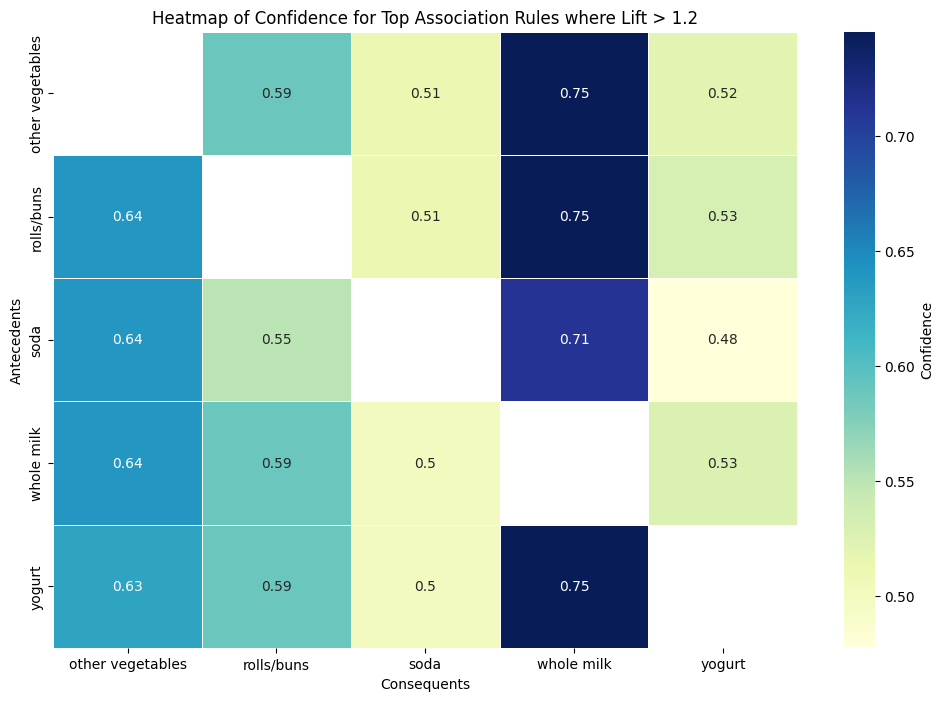

In [53]:
# Heatmap of Confidence where Lift > 1.2
top_ants = expandedLift_df.groupby('antecedent')['support'].sum().nlargest(5).index
top_cons = expandedLift_df.groupby('consequent')['support'].sum().nlargest(5).index

filtered = expandedLift_df[
    (expandedLift_df['antecedent'].isin(top_ants)) &
    (expandedLift_df['consequent'].isin(top_cons))
]

filtered_unique = (
    filtered.groupby(['antecedent', 'consequent'], as_index=False)
    .agg({'confidence': 'max'})
)

heatmap_data = filtered_unique.pivot(
    index='antecedent', columns='consequent', values='confidence')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu',
            linewidths=0.5, cbar_kws={'label': 'Confidence'})
plt.title('Heatmap of Confidence for Top Association Rules where Lift > 1.2')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()